In [2]:
!pip install imbalanced-learn


     -------------------------------------- 238.4/238.4 kB 2.4 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install seaborn


     -------------------------------------- 294.9/294.9 kB 2.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# model_training_lite.ipynb

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Step 1: Load a few CSVs only
data_path = r"C:\Users\trish\Desktop\nids-ai\data\CICIDS2017\MachineLearningCVE" 

files_to_load = [
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Monday-WorkingHours.pcap_ISCX.csv"
]
df_list = []

In [3]:
for file in files_to_load:
    file_path = os.path.join(data_path, file)
    print(f"Reading {file_path} ...")
    df = pd.read_csv(file_path, low_memory=False)
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
print(f"Combined shape: {df.shape}")


Reading C:\Users\trish\Desktop\nids-ai\data\CICIDS2017\MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv ...
Reading C:\Users\trish\Desktop\nids-ai\data\CICIDS2017\MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv ...
Reading C:\Users\trish\Desktop\nids-ai\data\CICIDS2017\MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv ...
Combined shape: (946696, 79)


In [5]:
df_list = []

for file in files_to_load:
    file_path = os.path.join(data_path, file)
    print(f"Reading {file_path} ...")
    try:
        temp_df = pd.read_csv(file_path, low_memory=False)

        # Strip column names of extra whitespace
        temp_df.columns = temp_df.columns.str.strip()

        # Only add the file if it contains a 'Label' column
        if 'Label' in temp_df.columns:
            df_list.append(temp_df)
        else:
            print(f"⚠️ Skipped {file} (no 'Label' column)")

    except Exception as e:
        print(f"❌ Failed to read {file_path}: {e}")


Reading C:\Users\trish\Desktop\nids-ai\data\CICIDS2017\MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv ...
Reading C:\Users\trish\Desktop\nids-ai\data\CICIDS2017\MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv ...
Reading C:\Users\trish\Desktop\nids-ai\data\CICIDS2017\MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv ...


In [6]:
df = pd.concat(df_list, ignore_index=True)

In [7]:
# Step 2: Drop missing/duplicate data and unnecessary columns
df = df.dropna()
df = df.drop_duplicates()
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df[df.columns.drop(list(df.filter(regex='Flow ID|Timestamp')))]
df = df[df['Label'] != 'Label']  # remove repeated header rows


In [8]:
# Step 3: Sample smaller subset
df_sample = df.sample(n=100000, random_state=42)


In [9]:
# Step 4: Encode target and prepare features
label_encoder = LabelEncoder()
df_sample['Label'] = label_encoder.fit_transform(df_sample['Label'])


In [10]:
X = df_sample.drop('Label', axis=1)
y = df_sample['Label']

In [11]:
X = X.apply(pd.to_numeric, errors='coerce').fillna(-1)


In [13]:
import numpy as np

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaNs again (after removing infs)
X.fillna(-1, inplace=True)


In [14]:
scaler = QuantileTransformer(output_distribution='uniform')
X_scaled = scaler.fit_transform(X)


In [15]:
# Step 6: Use RandomOverSampler instead of full SMOTE (low memory)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_scaled, y)


In [16]:
# Step 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)


In [17]:
# Step 8: Train Model
rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [18]:
# Step 9: Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25550
           1       1.00      1.00      1.00     25846
           2       1.00      1.00      1.00     25789

    accuracy                           1.00     77185
   macro avg       1.00      1.00      1.00     77185
weighted avg       1.00      1.00      1.00     77185



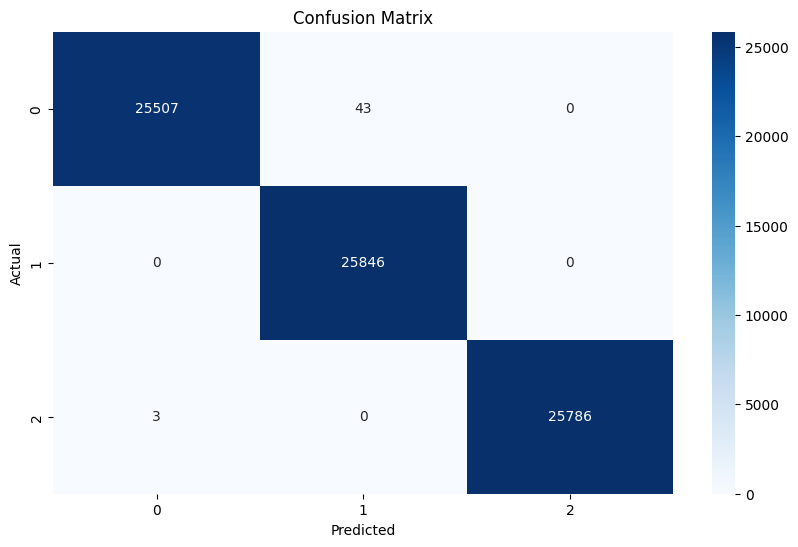

In [19]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
# Step 10: Save Model
joblib.dump(rf, '../models/random_forest_nids.pkl')
print("✅ Model saved at models/random_forest_nids.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '../models/random_forest_nids.pkl'